In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Data preprocessing
## loading train and test folders 

In [20]:
# Define transformations for train and test datasets
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
])

# Load datasets
train_dataset = datasets.ImageFolder(root='/kaggle/input/shoes-ds/train', transform=transform_test)
test_dataset = datasets.ImageFolder(root='/kaggle/input/shoes-ds/test', transform=transform_test)



# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


# CNN Architecture

In [21]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.05),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.fc_layer = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(256 * 28 * 28, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(512, 3)  # 3 classes: Nike, Adidas, Converse
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return x


#  Training the Model
### Set Loss Function and Optimizer

In [22]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)


### Train the Model 

In [23]:
n_epochs = 20
train_loss_history = []

for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0
    
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_loss_history.append(train_loss)
    
    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}")


Epoch 1/20, Train Loss: 1.0925
Epoch 2/20, Train Loss: 1.0593
Epoch 3/20, Train Loss: 1.0112
Epoch 4/20, Train Loss: 0.9736
Epoch 5/20, Train Loss: 0.9166
Epoch 6/20, Train Loss: 0.8674
Epoch 7/20, Train Loss: 0.7978
Epoch 8/20, Train Loss: 0.7443
Epoch 9/20, Train Loss: 0.6820
Epoch 10/20, Train Loss: 0.6384
Epoch 11/20, Train Loss: 0.5492
Epoch 12/20, Train Loss: 0.5101
Epoch 13/20, Train Loss: 0.4443
Epoch 14/20, Train Loss: 0.3849
Epoch 15/20, Train Loss: 0.3257
Epoch 16/20, Train Loss: 0.2756
Epoch 17/20, Train Loss: 0.2326
Epoch 18/20, Train Loss: 0.1847
Epoch 19/20, Train Loss: 0.1581
Epoch 20/20, Train Loss: 0.1333


# Test the Model

In [24]:
from sklearn.metrics import accuracy_score

# Set model to evaluation mode
model.eval()

# Track predictions and actual labels
all_preds = []
all_labels = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 57.02%


# Visualize Training Loss

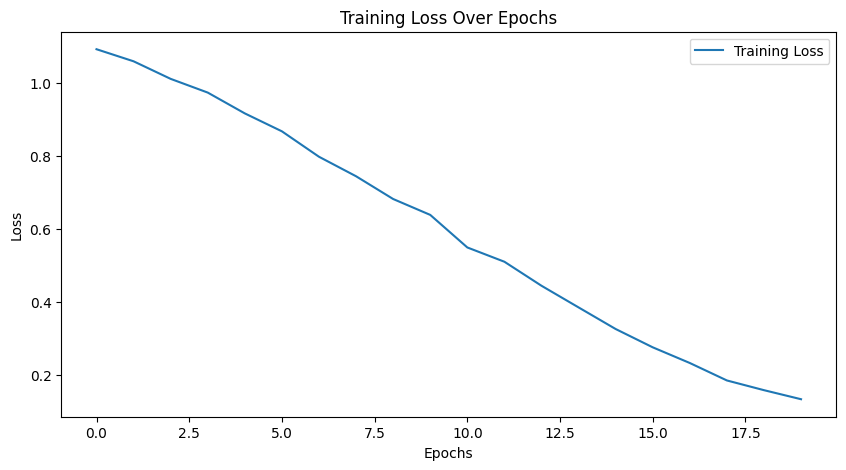

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()


# Evaluate the Model
### Precision, Recall, F1-Score

100%|██████████| 15/15 [00:00<00:00, 18.72it/s]


✅ **Test Accuracy:** 57.02%
🎯 **Precision:** 0.58
🎯 **Recall:** 0.57
🎯 **F1 Score:** 0.57
📉 **Average Test Loss:** 1.0833

📊 **Classification Report:**

              precision    recall  f1-score   support

        Nike       0.58      0.50      0.54        38
      Adidas       0.53      0.74      0.62        38
    Converse       0.64      0.47      0.55        38

    accuracy                           0.57       114
   macro avg       0.58      0.57      0.57       114
weighted avg       0.58      0.57      0.57       114



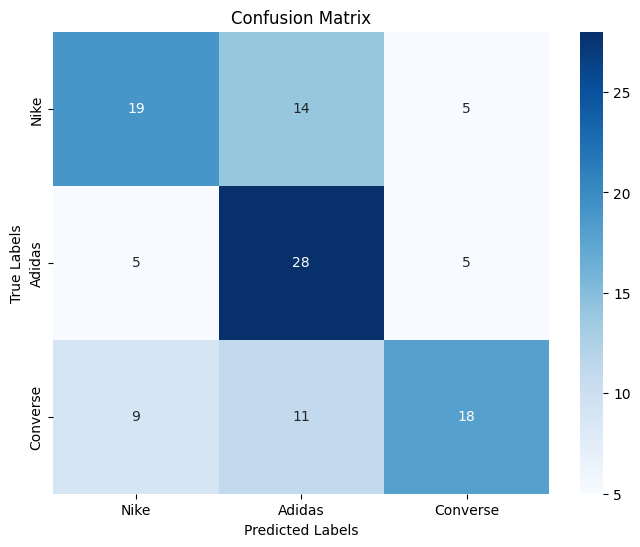

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Ensure the model is in evaluation mode
model.eval()

# Initialize variables for metrics
all_preds = []
all_labels = []
test_loss = 0.0

with torch.no_grad():
    for data, labels in tqdm(test_loader):
        data, labels = data.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        # Predictions and labels
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to NumPy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Get unique class labels from the test dataset
unique_labels = np.unique(all_labels)
class_names = ['Nike', 'Adidas', 'Converse']

# Filter class names based on unique labels
available_classes = [class_names[i] for i in unique_labels]

# Calculate Overall Metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

print(f"✅ **Test Accuracy:** {accuracy * 100:.2f}%")
print(f"🎯 **Precision:** {precision:.2f}")
print(f"🎯 **Recall:** {recall:.2f}")
print(f"🎯 **F1 Score:** {f1:.2f}")
print(f"📉 **Average Test Loss:** {test_loss / len(test_loader):.4f}")

# Print a detailed classification report for available classes only
print("\n📊 **Classification Report:**\n")
print(classification_report(all_labels, all_preds, target_names=available_classes, zero_division=0))

# Confusion Matrix for available classes
cm = confusion_matrix(all_labels, all_preds, labels=unique_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=available_classes, yticklabels=available_classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


### Visualization of Class-Wise Performance

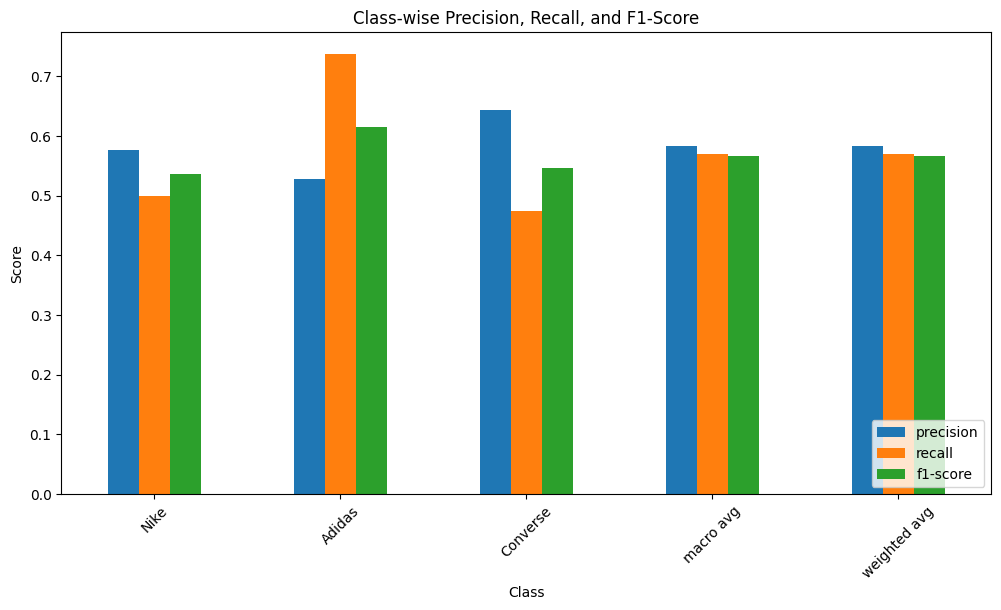

In [27]:
import pandas as pd

# Parse classification report into a DataFrame
report_df = pd.DataFrame.from_dict(classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)).transpose()
report_df = report_df.drop(['accuracy'], axis=0)

# Plot precision, recall, and F1-score
report_df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(12, 6))
plt.title('Class-wise Precision, Recall, and F1-Score')
plt.ylabel('Score')
plt.xlabel('Class')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.show()


##  **2. Define New Hyperparameters**

###  **Hyperparameter Grid**

| Experiment | Learning Rate | Batch Size | Dropout Rate | Optimizer | Epochs |
|------------|---------------|------------|-------------|-----------|--------|
| **Exp1**   | 0.001         | 16         | 0.1         | Adam      | 20     |
| **Exp2**   | 0.0005        |  8         | 0.2         | Adam      | 25     |
| **Exp3**   | 0.01          | 12         | 0.1         | SGD       | 30     |
| **Exp4**   | 0.0001        |  8        | 0.3         | RMSprop   | 25     |

In [28]:
from torch.optim import Adam, SGD, RMSprop
from torch.optim.lr_scheduler import StepLR

# Define different hyperparameter configurations
experiments = [
    {'name': 'Exp1', 'lr': 0.001, 'batch_size': 16, 'dropout': 0.1, 'optimizer': Adam, 'epochs': 20},
    {'name': 'Exp2', 'lr': 0.0005, 'batch_size': 8, 'dropout': 0.2, 'optimizer': Adam, 'epochs': 25},
    {'name': 'Exp3', 'lr': 0.01, 'batch_size': 12, 'dropout': 0.1, 'optimizer': SGD, 'epochs': 30},
    {'name': 'Exp4', 'lr': 0.0001, 'batch_size': 8, 'dropout': 0.3, 'optimizer': RMSprop, 'epochs': 25}
]

# Define results dictionary
experiment_results = []

for exp in experiments:
    print(f"🚀 Running Experiment: {exp['name']}")
    
    # Adjust DataLoader based on batch size
    train_loader = DataLoader(train_dataset, batch_size=exp['batch_size'], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=exp['batch_size'], shuffle=False)
    
    # Update dropout in the model dynamically
    class CNN(nn.Module):
        def __init__(self):
            super(CNN, self).__init__()
            self.conv_layer = nn.Sequential(
                nn.Conv2d(3, 32, kernel_size=3, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),
                nn.Conv2d(32, 64, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2, 2),
                nn.Conv2d(64, 128, kernel_size=3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.Conv2d(128, 128, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2, 2),
                nn.Dropout2d(exp['dropout']),
                nn.Conv2d(128, 256, kernel_size=3, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2, 2)
            )

            self.fc_layer = nn.Sequential(
                nn.Dropout(exp['dropout']),
                nn.Linear(256 * 28 * 28, 1024),
                nn.ReLU(inplace=True),
                nn.Linear(1024, 512),
                nn.ReLU(inplace=True),
                nn.Dropout(exp['dropout']),
                nn.Linear(512, 3)
            )

        def forward(self, x):
            x = self.conv_layer(x)
            x = x.view(x.size(0), -1)
            x = self.fc_layer(x)
            return x

    model = CNN().to(device)
    optimizer = exp['optimizer'](model.parameters(), lr=exp['lr'])
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
    criterion = nn.CrossEntropyLoss()

    # Training
    for epoch in range(exp['epochs']):
        model.train()
        train_loss = 0.0
        
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        scheduler.step()
        print(f"Epoch {epoch+1}/{exp['epochs']}, Loss: {train_loss/len(train_loader):.4f}")

    # Testing
    model.eval()
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            test_total += target.size(0)
            test_correct += (predicted == target).sum().item()
    
    test_accuracy = 100 * test_correct / test_total
    print(f"✅ Experiment {exp['name']} - Test Accuracy: {test_accuracy:.2f}%")

    # Store results
    experiment_results.append({
        'name': exp['name'],
        'lr': exp['lr'],
        'batch_size': exp['batch_size'],
        'dropout': exp['dropout'],
        'optimizer': exp['optimizer'].__name__,
        'epochs': exp['epochs'],
        'accuracy': test_accuracy
    })


🚀 Running Experiment: Exp1
Epoch 1/20, Loss: 2.5346
Epoch 2/20, Loss: 1.0991
Epoch 3/20, Loss: 1.0993
Epoch 4/20, Loss: 1.0991
Epoch 5/20, Loss: 1.0994
Epoch 6/20, Loss: 1.0991
Epoch 7/20, Loss: 1.0992
Epoch 8/20, Loss: 1.0991
Epoch 9/20, Loss: 1.0987
Epoch 10/20, Loss: 1.0991
Epoch 11/20, Loss: 1.0987
Epoch 12/20, Loss: 1.0987
Epoch 13/20, Loss: 1.0988
Epoch 14/20, Loss: 1.0988
Epoch 15/20, Loss: 1.0988
Epoch 16/20, Loss: 1.0987
Epoch 17/20, Loss: 1.0987
Epoch 18/20, Loss: 1.0987
Epoch 19/20, Loss: 1.0987
Epoch 20/20, Loss: 1.0987
✅ Experiment Exp1 - Test Accuracy: 33.33%
🚀 Running Experiment: Exp2
Epoch 1/25, Loss: 1.4470
Epoch 2/25, Loss: 1.0994
Epoch 3/25, Loss: 1.0990
Epoch 4/25, Loss: 1.0992
Epoch 5/25, Loss: 1.0992
Epoch 6/25, Loss: 1.0992
Epoch 7/25, Loss: 1.0991
Epoch 8/25, Loss: 1.0990
Epoch 9/25, Loss: 1.0989
Epoch 10/25, Loss: 1.0992
Epoch 11/25, Loss: 1.0987
Epoch 12/25, Loss: 1.0985
Epoch 13/25, Loss: 1.0984
Epoch 14/25, Loss: 1.0987
Epoch 15/25, Loss: 1.0987
Epoch 16/25,

# Compare Experiment Results

   name      lr  batch_size  dropout optimizer  epochs   accuracy
0  Exp1  0.0010          16      0.1      Adam      20  33.333333
1  Exp2  0.0005           8      0.2      Adam      25  33.333333
2  Exp3  0.0100          12      0.1       SGD      30  62.280702
3  Exp4  0.0001           8      0.3   RMSprop      25  60.526316


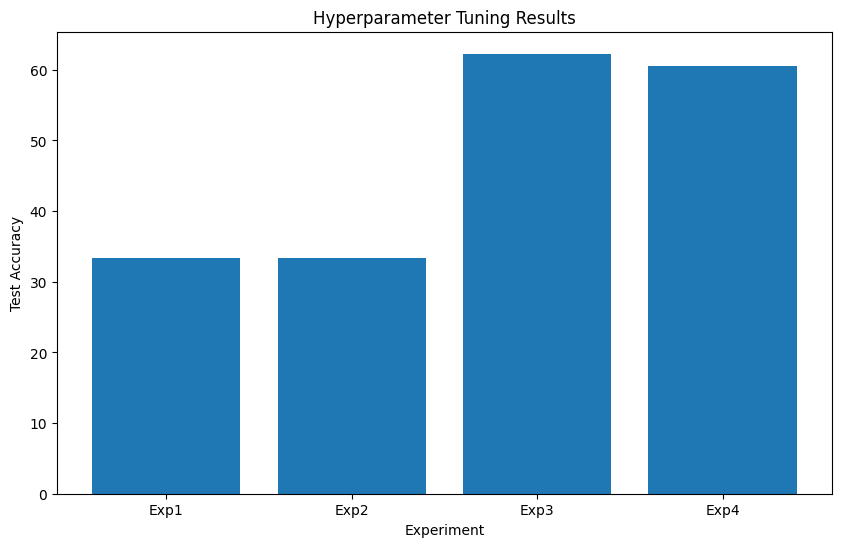

In [29]:
import pandas as pd

results_df = pd.DataFrame(experiment_results)
print(results_df)

# Plot Accuracy for each experiment
plt.figure(figsize=(10, 6))
plt.bar(results_df['name'], results_df['accuracy'])
plt.xlabel('Experiment')
plt.ylabel('Test Accuracy')
plt.title('Hyperparameter Tuning Results')
plt.show()


# Enhancing Model Performance Using ResNet50 Backbone

In [44]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset

# Define transformations for dataset augmentation (No Normalization)
transform_original = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

transform_flip_horizontal = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=1.0),  # Always flip horizontally
    transforms.ToTensor()
])


# Load the original dataset
train_dataset_original = datasets.ImageFolder(
    root='/kaggle/input/shoes-ds/train',
    transform=transform_original
)

# Load the horizontally flipped dataset
train_dataset_flip_horizontal = datasets.ImageFolder(
    root='/kaggle/input/shoes-ds/train',
    transform=transform_flip_horizontal
)

# Concatenate datasets
train_dataset = ConcatDataset([
    train_dataset_original,
    train_dataset_flip_horizontal,
])

# Load the test dataset (No Normalization)
test_dataset = datasets.ImageFolder(
    root='/kaggle/input/shoes-ds/test',
    transform=transform_original
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=12, shuffle=False, num_workers=2)

print(f"✅ Training Dataset Size (Augmented): {len(train_dataset)}")
print(f"✅ Test Dataset Size: {len(test_dataset)}")


✅ Training Dataset Size (Augmented): 1422
✅ Test Dataset Size: 114


In [57]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch

# Define the pre-trained ResNet50 model
class EnhancedResNet(nn.Module):
    def __init__(self):
        super(EnhancedResNet, self).__init__()
        
        # Load ResNet50 pre-trained on ImageNet with updated weights parameter
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        
        # Freeze all layers except the last few (optional)
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        # Modify the fully connected layer for our 3 classes
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 3)  # 3 classes: Nike, Adidas, Converse
        )

    def forward(self, x):
        return self.resnet(x)

# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EnhancedResNet().to(device)


# Set Up Optimizer and Loss Function

In [61]:
# Define optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.resnet.fc.parameters(), lr=0.0001, weight_decay=1e-3)


# Train the Model

In [62]:
# Training loop
n_epochs = 30
train_loss_history = []

for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0
    
    for data, target in tqdm(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {train_loss/len(train_loader):.4f}")


100%|██████████| 119/119 [00:05<00:00, 22.81it/s]


Epoch 1/30, Loss: 0.3356


100%|██████████| 119/119 [00:05<00:00, 22.89it/s]


Epoch 2/30, Loss: 0.3559


100%|██████████| 119/119 [00:05<00:00, 22.80it/s]


Epoch 3/30, Loss: 0.3444


100%|██████████| 119/119 [00:05<00:00, 22.46it/s]


Epoch 4/30, Loss: 0.3186


100%|██████████| 119/119 [00:05<00:00, 22.59it/s]


Epoch 5/30, Loss: 0.2907


100%|██████████| 119/119 [00:05<00:00, 22.56it/s]


Epoch 6/30, Loss: 0.2752


100%|██████████| 119/119 [00:05<00:00, 22.63it/s]


Epoch 7/30, Loss: 0.3523


100%|██████████| 119/119 [00:05<00:00, 22.58it/s]


Epoch 8/30, Loss: 0.2783


100%|██████████| 119/119 [00:05<00:00, 22.67it/s]


Epoch 9/30, Loss: 0.2868


100%|██████████| 119/119 [00:05<00:00, 22.70it/s]


Epoch 10/30, Loss: 0.2864


100%|██████████| 119/119 [00:05<00:00, 22.67it/s]


Epoch 11/30, Loss: 0.2816


100%|██████████| 119/119 [00:05<00:00, 22.85it/s]


Epoch 12/30, Loss: 0.2656


100%|██████████| 119/119 [00:05<00:00, 22.95it/s]


Epoch 13/30, Loss: 0.2397


100%|██████████| 119/119 [00:05<00:00, 22.96it/s]


Epoch 14/30, Loss: 0.2597


100%|██████████| 119/119 [00:05<00:00, 22.90it/s]


Epoch 15/30, Loss: 0.2432


100%|██████████| 119/119 [00:05<00:00, 23.00it/s]


Epoch 16/30, Loss: 0.2650


100%|██████████| 119/119 [00:05<00:00, 22.68it/s]


Epoch 17/30, Loss: 0.2560


100%|██████████| 119/119 [00:05<00:00, 22.98it/s]


Epoch 18/30, Loss: 0.2633


100%|██████████| 119/119 [00:05<00:00, 22.87it/s]


Epoch 19/30, Loss: 0.2791


100%|██████████| 119/119 [00:05<00:00, 22.88it/s]


Epoch 20/30, Loss: 0.2351


100%|██████████| 119/119 [00:05<00:00, 22.82it/s]


Epoch 21/30, Loss: 0.2667


100%|██████████| 119/119 [00:05<00:00, 22.82it/s]


Epoch 22/30, Loss: 0.2152


100%|██████████| 119/119 [00:05<00:00, 22.55it/s]


Epoch 23/30, Loss: 0.2402


100%|██████████| 119/119 [00:05<00:00, 22.77it/s]


Epoch 24/30, Loss: 0.2369


100%|██████████| 119/119 [00:05<00:00, 22.68it/s]


Epoch 25/30, Loss: 0.2250


100%|██████████| 119/119 [00:05<00:00, 22.78it/s]


Epoch 26/30, Loss: 0.2208


100%|██████████| 119/119 [00:05<00:00, 22.82it/s]


Epoch 27/30, Loss: 0.2991


100%|██████████| 119/119 [00:05<00:00, 22.78it/s]


Epoch 28/30, Loss: 0.2023


100%|██████████| 119/119 [00:05<00:00, 22.70it/s]


Epoch 29/30, Loss: 0.2096


100%|██████████| 119/119 [00:05<00:00, 22.79it/s]

Epoch 30/30, Loss: 0.2013


# Evaluation and Metrics Calculation

100%|██████████| 10/10 [00:00<00:00, 14.59it/s]


✅ Test Accuracy: 89.47%
🎯 Precision: 0.90
🎯 Recall: 0.89
🎯 F1 Score: 0.90
📉 Average Test Loss: 0.3687

📊 Classification Report:

              precision    recall  f1-score   support

        Nike       0.92      0.89      0.91        38
      Adidas       0.94      0.87      0.90        38
    Converse       0.83      0.92      0.88        38

    accuracy                           0.89       114
   macro avg       0.90      0.89      0.90       114
weighted avg       0.90      0.89      0.90       114



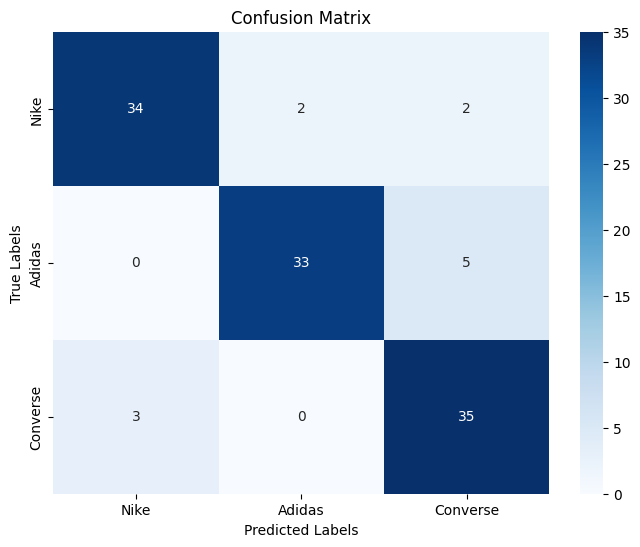

In [63]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Evaluate the model
model.eval()
all_preds = []
all_labels = []
test_loss = 0.0

with torch.no_grad():
    for data, labels in tqdm(test_loader):
        data, labels = data.to(device), labels.to(device)
        outputs = model(data)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

print(f"✅ Test Accuracy: {accuracy * 100:.2f}%")
print(f"🎯 Precision: {precision:.2f}")
print(f"🎯 Recall: {recall:.2f}")
print(f"🎯 F1 Score: {f1:.2f}")
print(f"📉 Average Test Loss: {test_loss / len(test_loader):.4f}")

# Classification Report
class_names = ['Nike', 'Adidas', 'Converse']
print("\n📊 Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
